# Librerías

In [1]:
# import libraries
import pandas as pd
import os
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import wikipediaapi
from collections import defaultdict

# Cargar y unir datasets

## Cargar todos los csv


In [2]:
DATA_DIR = "../raw_data"

FILES = {
    "municipios_base": "municipios_madrid_menores_50000.csv",
    "centros_salud": "recursos-y-asistencia-sanitaria.-centros-por-tipo-de-centro.-municipios.csv",
    "farmacias": "recursos-sanitarios.-farmacias.csv",
    "google_data": "municipios_google_data.csv",
    "paro_total": "total-paro-registrado.csv",
    "paro_por100": "paro-registrado-por-100-habitantes.csv",
    "cultura": "numero de intereses culturales.csv",
    "distancia": "distancia-a-la-capital_2016.csv",
    "vivienda": "IPVA 2023 VIVIENDA.csv",
    "afiliados": "afiliados-por-lugar-de-residencia-y-actividad.-municipios.csv",
    "alumnos": "alumnos-no-universitarios-del-regimen-general-matriculados-en-centros-escolares-por-tipo-de-cent.csv",
    "renta_municipal": "Renta_Disponible_Bruta_Municipal_total.csv",
}

# === FUNCIONES ===
def cargar_csv_detectando_sep(path):
    """Carga CSV detectando separador y codificación automáticamente."""
    for sep in [",", ";"]:
        try:
            df_test = pd.read_csv(path, sep=sep, nrows=5)
            if len(df_test.columns) > 1:
                full_df = pd.read_csv(path, sep=sep)
                return full_df, sep, None
        except Exception:
            continue
    for encoding in ["utf-8", "ISO-8859-1"]:
        for sep in [",", ";"]:
            try:
                full_df = pd.read_csv(path, sep=sep, encoding=encoding)
                if len(full_df.columns) > 1:
                    return full_df, sep, encoding
            except Exception:
                continue
    return None, None, None

def explorar_dataset(nombre, path):
    """Carga y muestra información básica de un dataset."""
    print(f"\n {nombre} — {path}")
    df, sep, encoding = cargar_csv_detectando_sep(path)
    
    if df is None:
        print(" No se pudo cargar el archivo correctamente.")
        return None
    
    print(f" Separador: '{sep}' | Codificación: '{encoding}' | Filas: {len(df)} | Columnas: {len(df.columns)}")
    print(" Columnas:", list(df.columns)[:8], "..." if len(df.columns) > 8 else "")
    print(df.head(3))
    return df

def inspeccionar_texto(path, n=8):
    """Muestra algunas líneas del archivo en bruto para inspección manual."""
    print(f"\n Inspeccionando texto bruto de {path}:")
    try:
        with open(path, "r", encoding="utf-8") as f:
            for i, line in enumerate(f):
                print(line.strip())
                if i >= n:
                    break
    except UnicodeDecodeError:
        print(" Error de codificación UTF-8, probando ISO-8859-1...")
        with open(path, "r", encoding="ISO-8859-1") as f:
            for i, line in enumerate(f):
                print(line.strip())
                if i >= n:
                    break

# --- CARGA PRINCIPAL ---
def main():
    dfs = {}
    for name, filename in FILES.items():
        path = os.path.join(DATA_DIR, filename)
        if not os.path.exists(path):
            print(f" Archivo no encontrado: {path}")
            continue
        df = explorar_dataset(name, path)
        if df is not None:
            dfs[name] = df
        else:
            inspeccionar_texto(path)
    print("\n Exploración completa. DataFrames cargados:", list(dfs.keys()))
    return dfs

if __name__ == "__main__":
    dfs = main()



 municipios_base — ../raw_data\municipios_madrid_menores_50000.csv
 Separador: ',' | Codificación: 'None' | Filas: 155 | Columnas: 6
 Columnas: ['cod_municipio', 'municipio', 'latitud', 'longitud', 'altitud', 'poblacion'] 
   cod_municipio          municipio   latitud  longitud    altitud  poblacion
0             14       Acebeda (La)  41.08697 -3.624634  1266.5420       68.0
1             29            Ajalvir  40.53437 -3.481002   680.1722     4946.0
2             35  Alameda del Valle  40.91790 -3.843788  1109.9340      256.0

 centros_salud — ../raw_data\recursos-y-asistencia-sanitaria.-centros-por-tipo-de-centro.-municipios.csv
 Separador: ',' | Codificación: 'None' | Filas: 573 | Columnas: 7
 Columnas: ['Año', 'Tipo territorio', 'Código territorio', 'Territorio', 'Tipo', 'Medida', 'Valor'] 
    Año      Tipo territorio  Código territorio           Territorio  \
0  2024  Comunidad de Madrid                NaN  Comunidad de Madrid   
1  2024           Municipios               14.0

El archivo "numero de intereses culturales.csv" no sigue el formato de un csv regular, presenta 22 columnas pero hay un punto y coma extra en el final de cada fila. Adem'as, las conas son para numeros decimales y la primera y segunda fila son descriptivas. Por lo que se eliminaría las primeras filas, limpiar texto quitando el ; final y luego las cuatro primeras columnas los nombraríamos: "Tipo territorio", "Código territorio", "Territorio". A esto le añadimos las columnas años que van desde 2006 hasta el 2024. 

In [3]:
def cargar_cultura_limpia(path):
    """Carga y limpia el dataset de cultura (corrige ';' extra y pasa de ancho a largo)."""
    with open(path, "rb") as f:
        raw = f.read()

    # eliminar BOM si existe
    if raw.startswith(b'\xef\xbb\xbf'):
        raw = raw[len(b'\xef\xbb\xbf'):]
    text = raw.decode("ISO-8859-1", errors="replace")

    # limpiar saltos de línea
    lines = [ln.rstrip("\r\n") for ln in text.splitlines()]
    # saltar dos primeras líneas descriptivas
    data_lines = lines[2:]

    cleaned = []
    for ln in data_lines:
        ln = ln.replace('\ufeff', '').replace('\u200b', '').strip()
        # eliminar cualquier ';' extra al final
        while ln.endswith(';'):
            ln = ln[:-1]
        cleaned.append(ln)

    # detectar columnas esperadas (primer fila válida)
    expected_cols = None
    for ln in cleaned:
        parts = ln.split(';')
        if len(parts) >= 3:
            expected_cols = len(parts)
            break

    if expected_cols is None:
        raise ValueError("No se pudo inferir el número de columnas del fichero de cultura.")

    normalized = []
    for ln in cleaned:
        parts = ln.split(';')
        # eliminar columnas vacías extra al final
        while len(parts) > expected_cols and parts[-1] == '':
            parts = parts[:-1]
        # recortar o rellenar según corresponda
        if len(parts) > expected_cols:
            parts = parts[:expected_cols-1] + [';'.join(parts[expected_cols-1:])]
        if len(parts) < expected_cols:
            parts += [''] * (expected_cols - len(parts))
        normalized.append(';'.join(parts))

    # encabezado correcto
    years = [str(y) for y in range(2006, 2025)]
    header = ["Tipo territorio", "Código territorio", "Territorio"] + years
    csv_text = ";".join(header) + "\n" + "\n".join(normalized)

    # leer con pandas
    df = pd.read_csv(StringIO(csv_text), sep=';', decimal=',', dtype=str, engine='python')

    # quedarnos con los municipios
    df = df[df["Tipo territorio"] == "Municipios"]

    # pasar a formato largo
    df_long = df.melt(
        id_vars=["Código territorio", "Territorio"],
        var_name="Año",
        value_name="Valor"
    )

    # limpiar tipos
    df_long["Año"] = pd.to_numeric(df_long["Año"], errors="coerce").astype("Int64")
    df_long["Valor"] = (
        df_long["Valor"]
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    df_long["Valor"] = pd.to_numeric(df_long["Valor"], errors="coerce")

    print(f" Dataset 'cultura' cargado correctamente: {df_long.shape}")
    print(df_long.head(200))
    return df_long


# Ejemplo de uso
if __name__ == "__main__":
    df_cultura = cargar_cultura_limpia("../raw_data/numero de intereses culturales.csv")

dfs["cultura"] = df_cultura

 Dataset 'cultura' cargado correctamente: (3580, 4)
    Código territorio             Territorio   Año  Valor
0                0014           Acebeda (La)  <NA>    NaN
1                0029                Ajalvir  <NA>    NaN
2                0035      Alameda del Valle  <NA>    NaN
3                0040            Ãlamo (El)  <NA>    NaN
4                0053     AlcalÃ¡ de Henares  <NA>    NaN
..                ...                    ...   ...    ...
195              0170                 Batres  2006    2.0
196              0186  Becerril de la Sierra  2006    0.0
197              0199       Belmonte de Tajo  2006    0.0
198              0210          Berrueco (El)  2006    1.0
199              0203     Berzosa del Lozoya  2006    0.0

[200 rows x 4 columns]


In [4]:
def preparar_renta_municipal(df, year=2023):
    df = df.copy()
    
    # 1) Nos quedamos solo con la Serie 'Municipios'
    df["Serie"] = df["Serie"].astype(str).str.strip()
    df = df[df["Serie"] == "Municipios"].copy()
    
    # 2) Renombrar las columnas raras a algo más estándar
    #    (ajusta los nombres si en tu CSV real son distintos)
    df = df.rename(columns={
        "...2": "Código territorio",
        "...3": "Territorio"
    })
    
    # 3) Crear columnas Año y Valor a partir de la columna del año 2023
    year_col = str(year)
    if year_col not in df.columns:
        raise KeyError(f"No existe la columna del año {year} en el dataset de renta municipal.")
    
    df["Año"] = year
    df["Valor"] = df[year_col]
    
    # 4) Asegurar tipos
    df["Código territorio"] = pd.to_numeric(df["Código territorio"], errors="coerce").astype("Int64")
    df["Valor"] = pd.to_numeric(df["Valor"], errors="coerce")
    df["Territorio"] = df["Territorio"].astype(str).str.strip()
    
    # 5) Devolver exactamente las columnas que comentabas
    return df[["Código territorio", "Territorio", "Serie", "Año", "Valor"]]


## Limpieza y tranformación antes de unirse

In [4]:
def pipeline_general(df, year_col="Año", code_col="Código territorio", value_col="Valor", last_year=True, to_int=True, rename_value=None):
    """Función general para transformar datasets con estructura común"""
    df = df.copy()
    
    # Filtrar por último año
    if last_year and year_col in df.columns:
        # garantizar que el año se compare como numérico (puede haber NaNs)
        df_years = pd.to_numeric(df[year_col], errors="coerce")
        max_year = df_years.max()
        df = df[df_years == max_year]
    
    # Convertir código de municipio a entero nullable (soporta NA)
    if code_col in df.columns:
        df["cod_municipio"] = pd.to_numeric(df[code_col], errors="coerce").astype("Int64")
    
    # Renombrar columna de valor (si se pide)
    if rename_value and value_col in df.columns:
        df = df.rename(columns={value_col: rename_value})
    
    # determinar nombre final de la columna de valor
    target_value_col = rename_value if rename_value else value_col
    
    # Convertir columna valor a numérica (soporta coma como decimal si ya limpia; en caso contrario intenta conversión directa)
    if target_value_col in df.columns:
        # si es object, intentar limpiar separadores comunes (puntos miles, comas decimales)
        if df[target_value_col].dtype == object:
            # Reemplazos no destructivos: quitar espacios y convertir comas a puntos
            df[target_value_col] = (
                df[target_value_col]
                .astype(str)
                .str.replace(r"\s+", "", regex=True)
                .str.replace(".", "", regex=False)  # eliminar separadores de miles
                .str.replace(",", ".", regex=False)  # coma decimal -> punto
            )
        df[target_value_col] = pd.to_numeric(df[target_value_col], errors="coerce")
    
    return df

# --- Función específica para vivienda (más robusta) ---
def pipeline_vivienda(df):
    df = df.copy()

    # Si ya está procesado (columnas esperadas), devolver versión normalizada
    if {"cod_postal", "municipio", "IPVA"}.issubset(df.columns):
        df["cod_postal"] = pd.to_numeric(df["cod_postal"], errors="coerce").astype("Int64")
        df["IPVA"] = pd.to_numeric(df["IPVA"], errors="coerce")
        df["municipio"] = df["municipio"].astype(str).str.strip()
        return df[["cod_postal", "municipio", "IPVA"]].reset_index(drop=True)

    # Localizar columna que contiene municipio (acepta varias variantes)
    muni_col = None
    for c in ["Municipio", "Territorio", "municipio", "territorio"]:
        if c in df.columns:
            muni_col = c
            break
    if muni_col is None:
        raise KeyError("No se encontró columna de municipio. Buscando 'Municipio' o 'Territorio'.")

    # Localizar columna de periodo/año si existe
    period_col = None
    for c in ["Periodo", "Año", "Year"]:
        if c in df.columns:
            period_col = c
            break
    # Filtrar por último año ignorando valores nulos en periodo
    if period_col is not None:
        periodo_num = pd.to_numeric(df[period_col], errors="coerce")
        valid_periods = periodo_num.dropna()
        if not valid_periods.empty:
            last_year = valid_periods.max()
            df = df[periodo_num == last_year]

    # Normalizar texto de la columna municipio y separar código y nombre
    s = df[muni_col].astype(str).fillna("").str.strip()
    # reemplazar guiones largos por espacio y limpiar espacios extra
    s_clean = s.str.replace(r"[-–—]+", " ", regex=True).str.strip()
    parts = s_clean.str.split(r"\s+", n=1, expand=True)

    # Extraer dígitos iniciales como código postal/código municipio cuando existan
    first_part_digits = parts[0].str.extract(r"(\d+)", expand=False)
    df["cod_postal"] = pd.to_numeric(first_part_digits, errors="coerce").astype("Int64")

    # Si no hay segunda parte, usar la primera (útil si ya solo contiene nombre)
    df["municipio"] = parts[1].where(parts[1].notna(), parts[0]).astype(str).str.strip()

    # Localizar columna de valor (Total/IPVA u otras variantes)
    value_col = None
    for c in ["Total", "IPVA", "Valor", "Importe"]:
        if c in df.columns:
            value_col = c
            break
    if value_col is None:
        # intentar usar la primera columna numérica razonable
        numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
        # excluir columnas que claramente no son el valor buscado
        for excl in ["cod_postal"]:
            if excl in numeric_cols:
                numeric_cols.remove(excl)
        if numeric_cols:
            value_col = numeric_cols[0]

    if value_col is None:
        raise KeyError("No se encontró columna de valor (Total/IPVA/Valor) en el dataset de vivienda.")

    # Limpiar formato del valor y convertir a numérico
    df["IPVA"] = (
        df[value_col]
        .astype(str)
        .str.replace(r"\s+", "", regex=True)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    df["IPVA"] = pd.to_numeric(df["IPVA"], errors="coerce")

    return df[["cod_postal", "municipio", "IPVA"]].reset_index(drop=True)

# --- Función específica para cultura (maneja años nulos) ---
def pipeline_cultura(df):
    df = df.copy()
    # Filtrar por último año ignorando valores nulos en 'Año'
    if "Año" in df.columns:
        year_num = pd.to_numeric(df["Año"], errors="coerce")
        valid_years = year_num.dropna()
        if not valid_years.empty:
            last_year = valid_years.max()
            df = df[year_num == last_year]
        # si no hay años válidos, no filtramos (mantenemos todo)
    # convertir código a entero nullable (si existe)
    if "Código territorio" in df.columns:
        df["cod_municipio"] = pd.to_numeric(df["Código territorio"], errors="coerce").astype("Int64")
    else:
        # intentar encontrar columna parecida si cambia el nombre
        for c in df.columns:
            if "codigo" in c.lower() or "territorio" in c.lower():
                df["cod_municipio"] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
                break
    # asegurar Valor numérico si existe
    if "Valor" in df.columns:
        df["Valor"] = pd.to_numeric(df["Valor"], errors="coerce")
    return df[["cod_municipio", "Valor"]]

# Aplicar pipelines solo si existen las claves en dfs (evita KeyError)
if "centros_salud" in dfs:
    dfs["centros_salud"] = pipeline_general(dfs["centros_salud"], year_col="Año", code_col="Código territorio", value_col="Valor", rename_value="centros_salud")
if "farmacias" in dfs:
    dfs["farmacias"] = pipeline_general(dfs["farmacias"], rename_value="farmacias")
if "paro_total" in dfs:
    dfs["paro_total"] = pipeline_general(dfs["paro_total"], rename_value="paro_total")
if "paro_por100" in dfs:
    dfs["paro_por100"] = pipeline_general(dfs["paro_por100"], rename_value="paro_100")
if "distancia" in dfs:
    dfs["distancia"] = pipeline_general(dfs["distancia"], rename_value="distancia_capital")
if "vivienda" in dfs:
    dfs["vivienda"] = pipeline_vivienda(dfs["vivienda"])
if "afiliados" in dfs:
    dfs["afiliados"] = pipeline_general(dfs["afiliados"], rename_value="afiliados")
if "alumnos" in dfs:
    dfs["alumnos"] = pipeline_general(dfs["alumnos"], rename_value="alumnos")
if "cultura" in dfs:
    dfs["cultura"] = pipeline_cultura(dfs["cultura"])
if "renta_municipal" in dfs:
    # 1) Dejar solo Serie='Municipios' + Año 2023 y columna Valor
    renta_tmp = preparar_renta_municipal(dfs["renta_municipal"], year=2023)
    
    # 2) Pasarlo por tu pipeline_general para crear cod_municipio y valor numérico limpio
    dfs["renta_municipal"] = pipeline_general(
        renta_tmp,
        year_col="Año",
        code_col="Código territorio",
        value_col="Valor",
        rename_value="renta_municipal",  # nombre final de la columna de valor
        last_year=False  # ya hemos fijado explícitamente el año a 2023
    )
    
    dfs["renta_municipal"] = dfs["renta_municipal"][["Código territorio", "renta_municipal"]].reset_index(drop=True)


In [5]:
#  Revisar que todo se haya transformado correctamente
for name, df in dfs.items():
    print(f"\n{name.upper()} — Filas: {len(df)} | Columnas: {df.shape[1]}")
    print(df.head(5))


MUNICIPIOS_BASE — Filas: 155 | Columnas: 6
   cod_municipio          municipio   latitud  longitud    altitud  poblacion
0             14       Acebeda (La)  41.08697 -3.624634  1266.5420       68.0
1             29            Ajalvir  40.53437 -3.481002   680.1722     4946.0
2             35  Alameda del Valle  40.91790 -3.843788  1109.9340      256.0
3             40         Álamo (El)  40.22972 -3.992688   606.2238    10413.0
4             88   Aldea del Fresno  40.32399 -4.202217   476.7994     3422.0

CENTROS_SALUD — Filas: 573 | Columnas: 8
    Año      Tipo territorio  Código territorio           Territorio  \
0  2024  Comunidad de Madrid                NaN  Comunidad de Madrid   
1  2024           Municipios               14.0         Acebeda (La)   
2  2024           Municipios               29.0              Ajalvir   
3  2024           Municipios               35.0    Alameda del Valle   
4  2024           Municipios               40.0           Álamo (El)   

             

## Unión de datasets: DATASET COMPLETO

In [6]:
# === FUNCIONES AUXILIARES ===

def preparar_afiliados(df):
    """Convierte afiliados (one-to-many) a formato ancho por rama de actividad.
    Normaliza la columna 'Rama de actividad' (minúsculas, sin espacios ni caracteres inválidos)
    antes del pivot.
    """
    df = df.copy()
    # Normalizar texto
    df["Rama de actividad"] = df["Rama de actividad"].astype(str).str.strip().str.lower()
    # Reemplazar espacios por guiones bajos y eliminar caracteres no alfanuméricos/guión bajo
    df["rama_norm"] = (
        df["Rama de actividad"]
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^\w]", "", regex=True)
    )
    # Asegurar que 'afiliados' es numérico
    df["afiliados"] = pd.to_numeric(df.get("afiliados"), errors="coerce").fillna(0)
    # Pivotear
    df_pivot = df.pivot_table(
        index="cod_municipio",
        columns="rama_norm",
        values="afiliados",
        aggfunc="sum",
        fill_value=0,
    ).reset_index()
    # Renombrar columnas de salida
    df_pivot.columns = ["cod_municipio"] + [f"afiliados_{c}" for c in df_pivot.columns[1:]]
    return df_pivot

def preparar_alumnos(df):
    """Agrupa por municipio para obtener el total de alumnos no universitarios."""
    df = df.copy()
    df["alumnos"] = pd.to_numeric(df["alumnos"], errors="coerce")
    df_agg = df.groupby("cod_municipio", as_index=False)["alumnos"].sum()
    df_agg = df_agg.rename(columns={"alumnos": "alumnos_total"})
    return df_agg

def preparar_cultura(df):
    df = df.copy()
    df = df.rename(columns={"Valor": "cultura"})
    return df[["cod_municipio", "cultura"]]

def preparar_centros_salud(df):
    df = df.copy()
    # Filtrar solo las filas donde la columna 'Tipo' indique 'Centros de salud'
    if "Tipo" in df.columns:
        df = df[df["Tipo"].astype(str).str.strip().str.lower() == "centros de salud"].copy()
    df = df.rename(columns={"centros_salud": "centros_salud_10mil"})
    return df[["cod_municipio", "centros_salud_10mil"]]

def preparar_farmacias(df):
    df = df.copy()
    df = df.rename(columns={"farmacias": "farmacias_10mil"})
    return df[["cod_municipio", "farmacias_10mil"]]

def preparar_vivienda(df):
    df = df.copy()
    df = df.rename(columns={"municipio": "municipio", "IPVA": "IPVA"})
    df["municipio"] = df["municipio"].str.strip().str.lower()
    return df[["municipio", "IPVA"]]

def preparar_municipios_base(df):
    df = df.copy()
    return df[["cod_municipio", "municipio", "latitud", "longitud", "altitud", "poblacion"]]

def preparar_renta_municipal(df):
    """Prepara renta municipal para unir por cod_municipio."""
    df = df.copy()
    # Partimos de columnas: "Código territorio", "renta_municipal"
    df["cod_municipio"] = pd.to_numeric(df["Código territorio"], errors="coerce").astype("Int64")
    return df[["cod_municipio", "renta_municipal"]]

# === PIPELINE DE UNIÓN ===
def unir_todos(dfs, output_path="df_final.csv"):
    # Base: municipios
    df_final = preparar_municipios_base(dfs["municipios_base"])

    def merge(df_dest, name, how="left", on="cod_municipio"):
        if name not in dfs:
            print(f" {name} no encontrado, se omite.")
            return df_dest

        print(f" Uniendo {name}...")
        df_src = dfs[name]
        result = df_dest.merge(df_src, on=on, how=how, suffixes=("", f"_{name}"))

        # Si se crean columnas municipio_x / municipio_y, mantener solo la de municipios_base
        for col in ["municipio_y", f"municipio_{name}"]:
            if col in result.columns:
                result.drop(columns=[col], inplace=True)
        if "municipio_x" in result.columns:
            result.rename(columns={"municipio_x": "municipio"}, inplace=True)

        return result

    # Preparar datasets específicos
    if "centros_salud" in dfs:
        dfs["centros_salud"] = preparar_centros_salud(dfs["centros_salud"])
    if "farmacias" in dfs:
        dfs["farmacias"] = preparar_farmacias(dfs["farmacias"])
    if "cultura" in dfs:
        dfs["cultura"] = preparar_cultura(dfs["cultura"])
    if "afiliados" in dfs:
        dfs["afiliados"] = preparar_afiliados(dfs["afiliados"])
    if "alumnos" in dfs:
        dfs["alumnos"] = preparar_alumnos(dfs["alumnos"])
    if "vivienda" in dfs:
        dfs["vivienda"] = preparar_vivienda(dfs["vivienda"])
    if "renta_municipal" in dfs:
        dfs["renta_municipal"] = preparar_renta_municipal(dfs["renta_municipal"])

    # Merge progresivo por cod_municipio
    for name in [
        "centros_salud",
        "farmacias",
        "google_data",
        "paro_total",
        "paro_por100",
        "distancia",
        "afiliados",
        "alumnos",
        "cultura",
        "renta_municipal",
    ]:
        df_final = merge(df_final, name)

    # Unir vivienda por municipio (texto)
    if "vivienda" in dfs:
        df_viv = dfs["vivienda"]
        df_final["municipio_norm"] = df_final["municipio"].str.strip().str.lower()
        df_viv["municipio"] = df_viv["municipio"].astype(str).str.strip().str.lower()

        df_final = df_final.merge(
            df_viv,
            left_on="municipio_norm",
            right_on="municipio",
            how="left"
        )
        df_final.drop(columns=["municipio_norm", "municipio_y"], inplace=True, errors="ignore")
        df_final.rename(columns={"municipio_x": "municipio"}, inplace=True)

    print(f"Filas: {len(df_final)} | Columnas: {df_final.shape[1]}")
    return df_final

# Unir y ver resultado final
df_final = unir_todos(dfs)


 Uniendo centros_salud...
 Uniendo farmacias...
 Uniendo google_data...
 Uniendo paro_total...
 Uniendo paro_por100...
 Uniendo distancia...
 Uniendo afiliados...
 Uniendo alumnos...
 Uniendo cultura...
 Uniendo renta_municipal...
Filas: 155 | Columnas: 122


In [7]:
# Definir columnas finales a conservar (base)
final_columns = [
    "cod_municipio", "municipio", "latitud", "longitud", "altitud", "poblacion",
    "centros_salud_10mil", "farmacias_10mil",
    "paro_total", "distancia_capital",
    "alumnos_total", "cultura", "IPVA", "renta_municipal"
]

# Añadir columnas que provienen de 'municipios_google_data' o 'google_data' (si existe)
mg_key = None
if "municipios_google_data" in dfs:
    mg_key = "municipios_google_data"
elif "google_data" in dfs:
    mg_key = "google_data"

if mg_key:
    mg_cols = list(dfs[mg_key].columns)
    for c in mg_cols:
        if c not in final_columns and c != "cod_municipio":
            final_columns.append(c)

# Filtrar solo las columnas que queremos conservar (incluye todas las 'afiliados_')
cols_to_keep = [c for c in df_final.columns if c in final_columns or c.startswith("afiliados_")]
df_final = df_final[cols_to_keep]

print(f"\n=== DATAFRAME FINAL UNIDO ===\nFilas: {len(df_final)} | Columnas: {df_final.shape[1]}")
print(df_final.head(10))
print(df_final.columns.tolist())


=== DATAFRAME FINAL UNIDO ===
Filas: 155 | Columnas: 103
   cod_municipio          municipio   latitud  longitud    altitud  poblacion  \
0             14       Acebeda (La)  41.08697 -3.624634  1266.5420       68.0   
1             29            Ajalvir  40.53437 -3.481002   680.1722     4946.0   
2             35  Alameda del Valle  40.91790 -3.843788  1109.9340      256.0   
3             40         Álamo (El)  40.22972 -3.992688   606.2238    10413.0   
4             88   Aldea del Fresno  40.32399 -4.202217   476.7994     3422.0   
5             91             Algete  40.59642 -3.497902   712.8972    21134.0   
6            105          Alpedrete  40.65875 -4.023713   916.7029    15655.0   
7            112             Ambite  40.32920 -3.181895   667.3380      701.0   
8            127           Anchuelo  40.46549 -3.268585   761.7067     1393.0   
9            151      Arroyomolinos  40.26884 -3.920291   597.4142    37299.0   

   centros_salud_10mil  farmacias_10mil  g_superme

# EDA (df_final)

In [8]:
# === EDA BÁSICO ===

# Ver dimensiones
print(" Dimensiones:", df_final.shape)

# Ver primeras filas
print("\n Vista previa:")
display(df_final.head())


 Dimensiones: (155, 103)

 Vista previa:


,cod_municipio,municipio,latitud,longitud,altitud,poblacion,centros_salud_10mil,farmacias_10mil,g_supermercados_count,g_supermercados_reviews,...,afiliados_construcción,afiliados_minería_industria_y_energía,afiliados_otros_servicios,afiliados_servicios_a_empresas_y_financieros,afiliados_servicios_de_distribución_y_hostelería,afiliados_total,alumnos_total,cultura,renta_municipal,IPVA
0,14,Acebeda (La),41.08697,-3.624634,1266.5420,68.0,0,0,0,0,...,1,2,8,8,11,30,0,0.0,1358164.0,NaN
1,29,Ajalvir,40.53437,-3.481002,680.1722,4946.0,0,2,6,2750,...,110,253,578,521,691,2168,1336,0.0,89374695.0,NaN
2,35,Alameda del Valle,40.91790,-3.843788,1109.9340,256.0,0,39,0,0,...,3,4,31,20,27,89,0,0.0,5349120.0,NaN
3,40,Álamo (El),40.22972,-3.992688,606.2238,10413.0,0,2,4,863,...,371,319,1164,773,1122,3771,4244,0.0,149091320.0,NaN
4,88,Aldea del Fresno,40.32399,-4.202217,476.7994,3422.0,0,3,2,1291,...,149,70,340,213,283,1082,566,0.0,49222914.0,NaN


In [9]:
# Resumen organizado de df_final: tipos, nulos, únicos, ejemplos y estadísticas numéricas
def df_overview(df, n_examples=3):
    rows = []
    for c in df.columns:
        s = df[c]
        rows.append({
            "column": c,
            "dtype": str(s.dtype),
            "non_null": int(s.notna().sum()),
            "pct_null": float((s.isna().mean()*100).round(2)),
            "n_unique": int(s.nunique(dropna=True)),
            "examples": s.dropna().unique()[:n_examples].tolist(),
            "min": s.min() if pd.api.types.is_numeric_dtype(s) else pd.NA,
            "max": s.max() if pd.api.types.is_numeric_dtype(s) else pd.NA,
            "mean": float(s.mean()) if pd.api.types.is_numeric_dtype(s) and s.notna().any() else pd.NA,
        })
    return pd.DataFrame(rows).sort_values(["pct_null", "n_unique"], ascending=[False, False]).reset_index(drop=True)

# Mostrar resumen (ordenado por % de nulos descendente)
display(df_overview(df_final, n_examples=4))

,column,dtype,non_null,pct_null,n_unique,examples,min,max,mean
0,g_bomberos_rating_wavg,float64,10,93.55,5,"[4.8, 4.4, 5.0, 4.7]",4.3,5.0,4.66
1,g_cines_rating_wavg,float64,16,89.68,10,"[4.0, 5.0, 3.7, 4.7]",3.7,5.0,4.46825
2,IPVA,float64,26,83.23,26,"[114.728, 118.558, 123.239, 117.607]",112.163,125.794,118.078192
3,g_centros_comerciales_rating_wavg,float64,32,79.35,21,"[4.245, 4.103, 3.9, 4.1]",3.143,5.0,4.05775
4,g_comisarias_rating_wavg,float64,51,67.10,19,"[3.7, 1.0, 5.0, 3.9]",1.0,5.0,3.943137
...,...,...,...,...,...,...,...,...,...
98,g_cines_count,int64,155,0.00,4,"[0, 1, 2, 3]",0,3,0.148387
99,g_ayuntamientos_count,int64,155,0.00,4,"[1, 2, 3, 0]",0,3,1.2
100,g_bomberos_count,int64,155,0.00,3,"[0, 1, 2]",0,2,0.129032
101,g_escuelas_infantiles_count,int64,155,0.00,2,"[20, 8]",8,20,19.922581


Durante el proceso de recopilación de datos a través de la Google Places API, se observó que hay indicadores referentes al número de establecimientos que presentan con frecuencia el valor 20 como recuento máximo.

Este fenómeno no refleja necesariamente la realidad del municipio, sino que se debe a una limitación inherente al propio funcionamiento de la API.

Google Places API, en su endpoint Nearby Search, devuelve como máximo 20 resultados por petición. Aunque la plataforma permite obtener hasta 60 resultados mediante paginación, esta funcionalidad requiere solicitar explícitamente las páginas adicionales mediante el uso del parámetro next_page_token. Si no se implementa este mecanismo —como ocurre en este proyecto, donde se empleó únicamente la primera página de resultados—, el valor máximo retornado por cada consulta queda restringido a 20 elementos.

En consecuencia, puede haver municipios donde podrían existir muchos más establecimientos del tipo consultado, el valor aparece truncado en 20, que es el límite de la respuesta inicial de la API, por temas de costes.

Por tanto, la presencia repetida del valor 20 no implica que ese sea el número real de establecimientos, sino que constituye un límite técnico de la fuente de datos utilizado en el proceso de recolección.

In [10]:
# Lista de variables organizada por tipo de dato

cols = df_final.columns.tolist()
dtype_map = df_final.dtypes.apply(lambda x: x.name).to_dict()

vars_by_dtype = defaultdict(list)
for c in cols:
    vars_by_dtype[dtype_map[c]].append(c)

print(f"Total variables: {len(cols)}\n")
for dt in sorted(vars_by_dtype.keys()):
    print(f"{dt} ({len(vars_by_dtype[dt])}):")
    for c in sorted(vars_by_dtype[dt]):
        print(f"  - {c}")
    print()

# Construir resumen de nulos (null_df) a partir de df_final
null_counts = df_final.isna().sum()
null_pct = (null_counts / len(df_final) * 100).round(2)
null_df = pd.DataFrame({"missing_count": null_counts, "missing_pct": null_pct})

# Mostrar solo las variables con valores faltantes
missing_vars = null_df[null_df["missing_count"] > 0].sort_values("missing_pct", ascending=False)
print(f"\nVariables con valores faltantes: {len(missing_vars)}")
display(missing_vars)

Total variables: 103

float64 (39):
  - IPVA
  - altitud
  - aq_co_value
  - aq_no2_value
  - aq_o3_value
  - aq_pm10_value
  - aq_pm25_value
  - aq_so2_value
  - cultura
  - distancia_capital
  - g_aparcamientos_rating_wavg
  - g_ayuntamientos_rating_wavg
  - g_bancos_rating_wavg
  - g_bares_rating_wavg
  - g_bomberos_rating_wavg
  - g_cafeterias_rating_wavg
  - g_cajeros_rating_wavg
  - g_centros_comerciales_rating_wavg
  - g_cines_rating_wavg
  - g_colegios_institutos_rating_wavg
  - g_comisarias_rating_wavg
  - g_conveniencia_rating_wavg
  - g_escuelas_infantiles_rating_wavg
  - g_estaciones_principales_rating_wavg
  - g_farmacias_rating_wavg
  - g_gasolineras_rating_wavg
  - g_gimnasios_rating_wavg
  - g_hospitales_clinicas_rating_wavg
  - g_juzgados_rating_wavg
  - g_medicos_familia_rating_wavg
  - g_paradas_bus_rating_wavg
  - g_parques_rating_wavg
  - g_restaurantes_rating_wavg
  - g_supermercados_rating_wavg
  - g_universidad_fp_rating_wavg
  - latitud
  - longitud
  - poblaci

,missing_count,missing_pct
g_bomberos_rating_wavg,145,93.55
g_cines_rating_wavg,139,89.68
IPVA,129,83.23
g_centros_comerciales_rating_wavg,123,79.35
g_comisarias_rating_wavg,104,67.10
g_medicos_familia_rating_wavg,72,46.45
g_cajeros_rating_wavg,71,45.81
g_conveniencia_rating_wavg,67,43.23
g_colegios_institutos_rating_wavg,66,42.58
g_bancos_rating_wavg,60,38.71


In [11]:
# Estadísticas numéricas solo para variables con valores faltantes
cols_missing = missing_vars.index.tolist()
print("\nResumen estadístico (solo variables con nulos):")
display(df_final[cols_missing].describe().T)


Resumen estadístico (solo variables con nulos):


,count,mean,std,min,25%,50%,75%,max
g_bomberos_rating_wavg,10.0,4.660000,0.291357,4.300,4.40000,4.7000,4.95000,5.000
g_cines_rating_wavg,16.0,4.468250,0.424981,3.700,4.20000,4.5000,4.79400,5.000
IPVA,26.0,118.078192,3.187073,112.163,116.22875,117.6385,120.17750,125.794
g_centros_comerciales_rating_wavg,32.0,4.057750,0.387572,3.143,3.90000,4.0780,4.21125,5.000
g_comisarias_rating_wavg,51.0,3.943137,0.830483,1.000,3.50000,4.0000,4.60000,5.000
g_medicos_familia_rating_wavg,83.0,3.964265,1.061074,1.000,3.32600,4.2800,4.78400,5.000
g_cajeros_rating_wavg,84.0,2.906226,0.845632,1.000,2.37425,2.8390,3.51025,5.000
g_conveniencia_rating_wavg,88.0,4.084443,0.516957,2.500,3.81375,4.0000,4.42500,5.000
g_colegios_institutos_rating_wavg,89.0,4.734303,0.289321,3.700,4.59800,4.8040,5.00000,5.000
g_bancos_rating_wavg,95.0,2.760168,0.696196,1.000,2.32100,2.6560,3.11800,4.512


Algunos NaN podrían venir de municipios sin gimnasios, colegios, farmacias, transporte registrados, etc. (no porque falte el dato, sino porque el valor es inexistente). Otros son porque quizás tengan pocas instalaciones o nadie haya puesto ninguna reseña. Lo exploraremos más a fondo. 

En el caso de 'IPVA', que presenta un 83.23% de null values, plantearíamos quitar esa columna. Esto se debe a que la dataset original contiene datos de municipios de toda España. Y muchos municipios, sobretodo pequeños, de Madrid no aparecían. Los municipios que no estaban presentes en el dataset originalmente los metían en una fila con valor municipio como 'Resto Madrid'con IPVA de 118,417. Es un valor cercano a la media de los municipios de los que sí tenemos datos, que es 118.078192.

In [12]:
# ---- CONFIGURACIÓN ----
# Lista de variables rating wavg con missing
missing_rating_vars = [
    'g_bomberos_rating_wavg', 'g_cines_rating_wavg', 'g_centros_comerciales_rating_wavg',
    'g_comisarias_rating_wavg', 'g_gimnasios_rating_wavg', 'g_medicos_familia_rating_wavg',
    'g_conveniencia_rating_wavg', 'g_cajeros_rating_wavg', 'g_bancos_rating_wavg',
    'g_colegios_institutos_rating_wavg', 'g_cafeterias_rating_wavg',
    'g_gasolineras_rating_wavg', 'g_aparcamientos_rating_wavg',
    'g_estaciones_principales_rating_wavg', 'g_farmacias_rating_wavg',
    'g_ayuntamientos_rating_wavg', 'g_supermercados_rating_wavg', 
    'g_restaurantes_rating_wavg', 'g_parques_rating_wavg', 'g_bares_rating_wavg'
]

# ===== MAPEAR CATEGORÍAS Y VARIABLES EXTRA =====
# key = base categoría (sin g_), value = variables ajenas a Google
categorias = {
    "g_bomberos": [],
    "g_cines": [],
    "g_centros_comerciales": [],
    "g_comisarias": [],
    "g_gimnasios": [],
    "g_medicos_familia": ['centros_salud_10mil'],
    "g_conveniencia": [],
    "g_cajeros": [],
    "g_bancos": [],
    "g_colegios_institutos": ['alumnos_total'],
    "g_cafeterias": [],
    "g_gasolineras": [],
    "g_aparcamientos": [],
    "g_estaciones_principales": [],
    "g_farmacias": ["farmacias_10mil"],   
    "g_ayuntamientos": [],
    "g_supermercados": []
}

# ---- GENERADOR AUTOMÁTICO (mostrar solo filas con NA en las columnas relevantes) ----
for var in missing_rating_vars:
    categoria = var.replace("_rating_wavg", "")     # ej: g_farmacias
    
    print(f"\n\n=== TABLA: {categoria.upper()} — variable: {var} ===\n")

    # columnas base Google
    cols = [
        "cod_municipio",
        "municipio",
        f"{categoria}_count",
        f"{categoria}_reviews",
        var
    ]

    # añadir extras no google si existen en df
    if categoria in categorias:
        extras = [c for c in categorias[categoria] if c in df_final.columns]
        cols.extend(extras)

    # filtrar columnas existentes
    cols = [c for c in cols if c in df_final.columns]

    if not cols:
        print("  (No hay columnas válidas para esta categoría en df_final)")
        continue

    # Seleccionar filas donde cualquiera de las columnas relevantes tenga NA
    df_sub = df_final[cols]
    mask_missing = df_sub.isna().any(axis=1)
    df_missing = df_sub[mask_missing]

    if df_missing.empty:
        print("  (No hay filas con NA en las columnas seleccionadas)")
    else:
        count_col = f"{categoria}_count"
        print(f"  Filas con NA: {len(df_missing)}")
        if count_col in df_missing.columns:
            print(f"  Valores únicos en {count_col}: {sorted(df_missing[count_col].unique().tolist())}")
            print(f"  Media de {count_col}: {df_missing[count_col].mean():.2f}")
        display(df_missing)




=== TABLA: G_BOMBEROS — variable: g_bomberos_rating_wavg ===

  Filas con NA: 145
  Valores únicos en g_bomberos_count: [0, 1, 2]
  Media de g_bomberos_count: 0.07


,cod_municipio,municipio,g_bomberos_count,g_bomberos_reviews,g_bomberos_rating_wavg
0,14,Acebeda (La),0,0,NaN
1,29,Ajalvir,0,0,NaN
2,35,Alameda del Valle,0,0,NaN
3,40,Álamo (El),0,0,NaN
5,91,Algete,0,0,NaN
...,...,...,...,...,...
149,1776,Villanueva del Pardillo,0,0,NaN
150,1795,Villar del Olmo,0,0,NaN
151,1809,Villarejo de Salvanés,0,0,NaN
153,1821,Villavieja del Lozoya,0,0,NaN




=== TABLA: G_CINES — variable: g_cines_rating_wavg ===

  Filas con NA: 139
  Valores únicos en g_cines_count: [0, 1]
  Media de g_cines_count: 0.01


,cod_municipio,municipio,g_cines_count,g_cines_reviews,g_cines_rating_wavg
0,14,Acebeda (La),0,0,NaN
1,29,Ajalvir,0,0,NaN
2,35,Alameda del Valle,0,0,NaN
3,40,Álamo (El),0,0,NaN
4,88,Aldea del Fresno,0,0,NaN
...,...,...,...,...,...
149,1776,Villanueva del Pardillo,0,0,NaN
150,1795,Villar del Olmo,0,0,NaN
151,1809,Villarejo de Salvanés,0,0,NaN
153,1821,Villavieja del Lozoya,0,0,NaN




=== TABLA: G_CENTROS_COMERCIALES — variable: g_centros_comerciales_rating_wavg ===

  Filas con NA: 123
  Valores únicos en g_centros_comerciales_count: [0, 1]
  Media de g_centros_comerciales_count: 0.03


,cod_municipio,municipio,g_centros_comerciales_count,g_centros_comerciales_reviews,g_centros_comerciales_rating_wavg
0,14,Acebeda (La),0,0,NaN
1,29,Ajalvir,0,0,NaN
2,35,Alameda del Valle,0,0,NaN
4,88,Aldea del Fresno,0,0,NaN
7,112,Ambite,0,0,NaN
...,...,...,...,...,...
149,1776,Villanueva del Pardillo,0,0,NaN
150,1795,Villar del Olmo,0,0,NaN
151,1809,Villarejo de Salvanés,1,0,NaN
153,1821,Villavieja del Lozoya,0,0,NaN




=== TABLA: G_COMISARIAS — variable: g_comisarias_rating_wavg ===

  Filas con NA: 104
  Valores únicos en g_comisarias_count: [0, 1, 2]
  Media de g_comisarias_count: 0.31


,cod_municipio,municipio,g_comisarias_count,g_comisarias_reviews,g_comisarias_rating_wavg
0,14,Acebeda (La),0,0,NaN
2,35,Alameda del Valle,0,0,NaN
6,105,Alpedrete,1,0,NaN
7,112,Ambite,0,0,NaN
8,127,Anchuelo,0,0,NaN
...,...,...,...,...,...
148,1782,Villanueva de Perales,0,0,NaN
149,1776,Villanueva del Pardillo,2,0,NaN
150,1795,Villar del Olmo,0,0,NaN
153,1821,Villavieja del Lozoya,0,0,NaN




=== TABLA: G_GIMNASIOS — variable: g_gimnasios_rating_wavg ===

  Filas con NA: 58
  Valores únicos en g_gimnasios_count: [0, 1, 3]
  Media de g_gimnasios_count: 0.26


,cod_municipio,municipio,g_gimnasios_count,g_gimnasios_reviews,g_gimnasios_rating_wavg
0,14,Acebeda (La),0,0,NaN
2,35,Alameda del Valle,0,0,NaN
7,112,Ambite,0,0,NaN
8,127,Anchuelo,0,0,NaN
10,164,Atazar (El),0,0,NaN
11,170,Batres,0,0,NaN
14,210,Berrueco (El),1,0,NaN
15,203,Berzosa del Lozoya,0,0,NaN
17,246,Braojos,0,0,NaN
20,278,Buitrago del Lozoya,1,0,NaN




=== TABLA: G_MEDICOS_FAMILIA — variable: g_medicos_familia_rating_wavg ===

  Filas con NA: 72
  Valores únicos en g_medicos_familia_count: [0, 1]
  Media de g_medicos_familia_count: 0.17


,cod_municipio,municipio,g_medicos_familia_count,g_medicos_familia_reviews,g_medicos_familia_rating_wavg,centros_salud_10mil
0,14,Acebeda (La),0,0,NaN,0
2,35,Alameda del Valle,0,0,NaN,0
8,127,Anchuelo,0,0,NaN,0
10,164,Atazar (El),0,0,NaN,0
11,170,Batres,0,0,NaN,0
...,...,...,...,...,...,...
144,1739,Villamanrique de Tajo,0,0,NaN,0
146,1757,Villamantilla,1,0,NaN,0
148,1782,Villanueva de Perales,1,0,NaN,0
150,1795,Villar del Olmo,0,0,NaN,0




=== TABLA: G_CONVENIENCIA — variable: g_conveniencia_rating_wavg ===

  Filas con NA: 67
  Valores únicos en g_conveniencia_count: [0, 1]
  Media de g_conveniencia_count: 0.03


,cod_municipio,municipio,g_conveniencia_count,g_conveniencia_reviews,g_conveniencia_rating_wavg
0,14,Acebeda (La),0,0,NaN
4,88,Aldea del Fresno,0,0,NaN
7,112,Ambite,0,0,NaN
8,127,Anchuelo,0,0,NaN
10,164,Atazar (El),0,0,NaN
...,...,...,...,...,...
138,1678,Velilla de San Antonio,1,0,NaN
148,1782,Villanueva de Perales,0,0,NaN
150,1795,Villar del Olmo,0,0,NaN
153,1821,Villavieja del Lozoya,0,0,NaN




=== TABLA: G_CAJEROS — variable: g_cajeros_rating_wavg ===

  Filas con NA: 71
  Valores únicos en g_cajeros_count: [0, 1, 2, 3]
  Media de g_cajeros_count: 0.31


,cod_municipio,municipio,g_cajeros_count,g_cajeros_reviews,g_cajeros_rating_wavg
0,14,Acebeda (La),0,0,NaN
2,35,Alameda del Valle,0,0,NaN
7,112,Ambite,0,0,NaN
8,127,Anchuelo,0,0,NaN
10,164,Atazar (El),0,0,NaN
...,...,...,...,...,...
145,1744,Villamanta,1,0,NaN
146,1757,Villamantilla,0,0,NaN
148,1782,Villanueva de Perales,0,0,NaN
150,1795,Villar del Olmo,0,0,NaN




=== TABLA: G_BANCOS — variable: g_bancos_rating_wavg ===

  Filas con NA: 60
  Valores únicos en g_bancos_count: [0, 1]
  Media de g_bancos_count: 0.05


,cod_municipio,municipio,g_bancos_count,g_bancos_reviews,g_bancos_rating_wavg
0,14,Acebeda (La),0,0,NaN
2,35,Alameda del Valle,0,0,NaN
7,112,Ambite,0,0,NaN
8,127,Anchuelo,0,0,NaN
10,164,Atazar (El),0,0,NaN
11,170,Batres,0,0,NaN
14,210,Berrueco (El),0,0,NaN
15,203,Berzosa del Lozoya,0,0,NaN
17,246,Braojos,0,0,NaN
18,259,Brea de Tajo,0,0,NaN




=== TABLA: G_COLEGIOS_INSTITUTOS — variable: g_colegios_institutos_rating_wavg ===

  Filas con NA: 66
  Valores únicos en g_colegios_institutos_count: [0, 1, 2, 3, 4, 5]
  Media de g_colegios_institutos_count: 1.74


,cod_municipio,municipio,g_colegios_institutos_count,g_colegios_institutos_reviews,g_colegios_institutos_rating_wavg,alumnos_total
0,14,Acebeda (La),1,0,NaN,0
2,35,Alameda del Valle,1,0,NaN,0
4,88,Aldea del Fresno,2,0,NaN,566
8,127,Anchuelo,0,0,NaN,330
10,164,Atazar (El),0,0,NaN,0
...,...,...,...,...,...,...
136,1659,Valdilecha,1,0,NaN,1128
142,1701,Villaconejos,2,0,NaN,728
144,1739,Villamanrique de Tajo,1,0,NaN,14
150,1795,Villar del Olmo,3,0,NaN,10




=== TABLA: G_CAFETERIAS — variable: g_cafeterias_rating_wavg ===

  Filas con NA: 44
  Valores únicos en g_cafeterias_count: [0, 1]
  Media de g_cafeterias_count: 0.05


,cod_municipio,municipio,g_cafeterias_count,g_cafeterias_reviews,g_cafeterias_rating_wavg
0,14,Acebeda (La),0,0,NaN
2,35,Alameda del Valle,0,0,NaN
7,112,Ambite,0,0,NaN
10,164,Atazar (El),0,0,NaN
11,170,Batres,0,0,NaN
15,203,Berzosa del Lozoya,0,0,NaN
18,259,Brea de Tajo,0,0,NaN
22,297,Cabanillas de la Sierra,0,0,NaN
28,357,Carabaña,0,0,NaN
32,395,Cervera de Buitrago,0,0,NaN




=== TABLA: G_GASOLINERAS — variable: g_gasolineras_rating_wavg ===

  Filas con NA: 60
  Valores únicos en g_gasolineras_count: [0]
  Media de g_gasolineras_count: 0.00


,cod_municipio,municipio,g_gasolineras_count,g_gasolineras_reviews,g_gasolineras_rating_wavg
0,14,Acebeda (La),0,0,NaN
2,35,Alameda del Valle,0,0,NaN
7,112,Ambite,0,0,NaN
8,127,Anchuelo,0,0,NaN
10,164,Atazar (El),0,0,NaN
11,170,Batres,0,0,NaN
13,199,Belmonte de Tajo,0,0,NaN
14,210,Berrueco (El),0,0,NaN
15,203,Berzosa del Lozoya,0,0,NaN
18,259,Brea de Tajo,0,0,NaN




=== TABLA: G_APARCAMIENTOS — variable: g_aparcamientos_rating_wavg ===

  Filas con NA: 53
  Valores únicos en g_aparcamientos_count: [0, 1, 2, 3, 4]
  Media de g_aparcamientos_count: 0.64


,cod_municipio,municipio,g_aparcamientos_count,g_aparcamientos_reviews,g_aparcamientos_rating_wavg
1,29,Ajalvir,3,0,NaN
2,35,Alameda del Valle,0,0,NaN
5,91,Algete,4,0,NaN
7,112,Ambite,0,0,NaN
11,170,Batres,0,0,NaN
13,199,Belmonte de Tajo,1,0,NaN
15,203,Berzosa del Lozoya,0,0,NaN
17,246,Braojos,0,0,NaN
22,297,Cabanillas de la Sierra,1,0,NaN
24,318,Cadalso de los Vidrios,0,0,NaN




=== TABLA: G_ESTACIONES_PRINCIPALES — variable: g_estaciones_principales_rating_wavg ===

  Filas con NA: 9
  Valores únicos en g_estaciones_principales_count: [1, 3, 4, 8, 11, 14]
  Media de g_estaciones_principales_count: 5.44


,cod_municipio,municipio,g_estaciones_principales_count,g_estaciones_principales_reviews,g_estaciones_principales_rating_wavg
0,14,Acebeda (La),4,0,NaN
13,199,Belmonte de Tajo,8,0,NaN
15,203,Berzosa del Lozoya,11,0,NaN
18,259,Brea de Tajo,3,0,NaN
57,698,Hiruela (La),1,0,NaN
95,1185,Puebla de la Sierra,1,0,NaN
127,1551,Valdaracete,4,0,NaN
129,1570,Valdelaguna,14,0,NaN
144,1739,Villamanrique de Tajo,3,0,NaN




=== TABLA: G_FARMACIAS — variable: g_farmacias_rating_wavg ===

  Filas con NA: 19
  Valores únicos en g_farmacias_count: [0, 1]
  Media de g_farmacias_count: 0.05


,cod_municipio,municipio,g_farmacias_count,g_farmacias_reviews,g_farmacias_rating_wavg,farmacias_10mil
0,14,Acebeda (La),0,0,NaN,0
10,164,Atazar (El),0,0,NaN,0
15,203,Berzosa del Lozoya,0,0,NaN,0
24,318,Cadalso de los Vidrios,0,0,NaN,3
32,395,Cervera de Buitrago,0,0,NaN,0
47,571,Fresno de Torote,0,0,NaN,4
57,698,Hiruela (La),0,0,NaN,0
58,702,Horcajo de la Sierra,0,0,NaN,0
65,783,Madarcos,0,0,NaN,0
80,973,Navarredonda y San Mamés,0,0,NaN,0




=== TABLA: G_AYUNTAMIENTOS — variable: g_ayuntamientos_rating_wavg ===

  Filas con NA: 19
  Valores únicos en g_ayuntamientos_count: [0]
  Media de g_ayuntamientos_count: 0.00


,cod_municipio,municipio,g_ayuntamientos_count,g_ayuntamientos_reviews,g_ayuntamientos_rating_wavg
23,301,Cabrera (La),0,0,NaN
24,318,Cadalso de los Vidrios,0,0,NaN
28,357,Carabaña,0,0,NaN
34,528,Chinchón,0,0,NaN
47,571,Fresno de Torote,0,0,NaN
51,626,Garganta de los Montes,0,0,NaN
52,632,Gargantilla del Lozoya y Pinilla de Buitrago,0,0,NaN
54,663,Griñón,0,0,NaN
64,9015,Lozoyuela-Navas-Sieteiglesias,0,0,NaN
71,875,Molinos (Los),0,0,NaN




=== TABLA: G_SUPERMERCADOS — variable: g_supermercados_rating_wavg ===

  Filas con NA: 28
  Valores únicos en g_supermercados_count: [0]
  Media de g_supermercados_count: 0.00


,cod_municipio,municipio,g_supermercados_count,g_supermercados_reviews,g_supermercados_rating_wavg
0,14,Acebeda (La),0,0,NaN
2,35,Alameda del Valle,0,0,NaN
7,112,Ambite,0,0,NaN
10,164,Atazar (El),0,0,NaN
11,170,Batres,0,0,NaN
17,246,Braojos,0,0,NaN
32,395,Cervera de Buitrago,0,0,NaN
47,571,Fresno de Torote,0,0,NaN
53,647,Gascones,0,0,NaN
57,698,Hiruela (La),0,0,NaN




=== TABLA: G_RESTAURANTES — variable: g_restaurantes_rating_wavg ===

  Filas con NA: 4
  Valores únicos en g_restaurantes_count: [0]
  Media de g_restaurantes_count: 0.00


,cod_municipio,municipio,g_restaurantes_count,g_restaurantes_reviews,g_restaurantes_rating_wavg
47,571,Fresno de Torote,0,0,NaN
103,1261,Robregordo,0,0,NaN
127,1551,Valdaracete,0,0,NaN
129,1570,Valdelaguna,0,0,NaN




=== TABLA: G_PARQUES — variable: g_parques_rating_wavg ===

  Filas con NA: 4
  Valores únicos en g_parques_count: [0, 2]
  Media de g_parques_count: 0.50


,cod_municipio,municipio,g_parques_count,g_parques_reviews,g_parques_rating_wavg
11,170,Batres,0,0,NaN
47,571,Fresno de Torote,0,0,NaN
127,1551,Valdaracete,0,0,NaN
146,1757,Villamantilla,2,0,NaN




=== TABLA: G_BARES — variable: g_bares_rating_wavg ===

  Filas con NA: 3
  Valores únicos en g_bares_count: [0]
  Media de g_bares_count: 0.00


,cod_municipio,municipio,g_bares_count,g_bares_reviews,g_bares_rating_wavg
47,571,Fresno de Torote,0,0,NaN
116,1436,Somosierra,0,0,NaN
134,1631,Valdepiélagos,0,0,NaN


El análisis de los valores nulos en las variables de valoración (rating_wavg) muestra que, en la gran mayoría de categorías, las instalaciones asociadas poseen un número muy reducido de establecimientos por municipio. En la mayor parte de los casos, los conteos oscilan entre 0 y 4 elementos. Esto explica que los valores de rating_wavg aparezcan como nulos: simplemente no existen reseñas disponibles en Google o el número de establecimientos es tan pequeño que no alcanza a generar valoraciones.

Esta interpretación se mantiene de forma consistente en casi todas las categorías, con una excepción notable: estaciones principales, donde existe al menos un municipio con alrededor de 14 estaciones principales, pero aun así no registra ninguna reseña asociada. Este caso particular podría indicar una limitación en la presencia de dichas estaciones en Google Maps, o bien un patrón de uso en el que estos puntos no suelen recibir valoraciones por parte de los usuarios.

Otro caso destacable se encuentra en colegios e institutos. Los valores únicos en g_colegios_institutos_count incluyen cantidades moderadas [0, 1, 2, 3, 4, 5]. Sin embargo, aun en municipios con un numero elevado de alumnado registrado (hasta 2360 alumnos), las reseñas a menudo aparecen como inexistentes. Esta situación puede deberse a dos posibles razones:

- Limitaciones en la recolección de datos mediante la API de Google, que podría no estar identificando correctamente los centros educativos.

- Ausencia real de reseñas, lo cual—si bien es menos intuitivo dado el tamaño de algunos centros—también es plausible, ya que los colegios e institutos suelen recibir muchas menos valoraciones públicas que otros servicios como comercios, hostelería o sanidad.

En resumen, los valores nulos en las métricas de valoración responden en su mayoría a la falta de establecimientos o a la ausencia de reseñas por parte de los usuarios. Únicamente en casos concretos, como estaciones principales o centros educativos, se observan patrones que podrían requerir una revisión de la calidad de los datos o de los criterios de búsqueda aplicados en la API de Google.

In [13]:
# Get all _count columns
count_cols = [col for col in df_final.columns if col.endswith("_count")]

# Calculate min and max for each _count column
count_ranges = df_final[count_cols].agg(['min', 'max']).T
count_ranges.columns = ['Min', 'Max']

display(count_ranges)

,Min,Max
g_supermercados_count,0,20
g_conveniencia_count,0,20
g_farmacias_count,0,20
g_bancos_count,0,20
g_cajeros_count,0,20
g_gasolineras_count,0,20
g_hospitales_clinicas_count,8,39
g_medicos_familia_count,0,20
g_escuelas_infantiles_count,8,20
g_colegios_institutos_count,0,27


In [14]:
# Filter rows where bomberos, comisarias, or ayuntamientos _count columns have values > 3
cols_to_check = ['g_bomberos_count', 'g_comisarias_count', 'g_ayuntamientos_count', 'g_juzgados_count']
cols_to_check = [col for col in cols_to_check if col in df_final.columns]

mask = (df_final[cols_to_check] > 10).any(axis=1)
result = df_final[mask][['cod_municipio', 'municipio'] + cols_to_check]

print(result)

     cod_municipio              municipio  g_bomberos_count  \
0               14           Acebeda (La)                 0   
1               29                Ajalvir                 0   
2               35      Alameda del Valle                 0   
3               40             Álamo (El)                 0   
4               88       Aldea del Fresno                 1   
..             ...                    ...               ...   
150           1795        Villar del Olmo                 0   
151           1809  Villarejo de Salvanés                 0   
152           1816   Villaviciosa de Odón                 1   
153           1821  Villavieja del Lozoya                 0   
154           1837              Zarzalejo                 0   

     g_comisarias_count  g_ayuntamientos_count  g_juzgados_count  
0                     0                      1                20  
1                     3                      2                20  
2                     0                   

Hay variables que después del estudio, se consideran recogidas erróneamente. Por lo que esos datos posteriormente no se use en el cálculo de índices de las diferentes dimensiones. Por ejemplo, g_juzgados.

# Preproceso

Los municipios sin oferta (sin gym, farmacia, colegio, transporte, etc.) tendrán 0 → reflejando falta de servicio.

Los municipios con servicios pero sin reseñas tendrán valores medios representativos. Por ejemplo, refleja disponibilidad educativa sin penalizar excesivamente por falta de reseñas.

En el caso de la columna de IPVA, se dropea.

In [15]:
df_clean = df_final.copy()

# Drop IPVA 
df_clean = df_clean.drop(columns=["IPVA"])

# Variables auxiliares por categoría
aux_vars = {
    "g_medicos_familia": ["centros_salud_10mil"],
    "g_colegios_institutos": ["alumnos_total"],
    "g_farmacias": ["farmacias_10mil"]
}

# Lista de rating vars con missing
missing_vars = [
    'g_bomberos_rating_wavg', 'g_cines_rating_wavg', 'g_centros_comerciales_rating_wavg',
    'g_comisarias_rating_wavg', 'g_gimnasios_rating_wavg', 'g_medicos_familia_rating_wavg',
    'g_conveniencia_rating_wavg', 'g_cajeros_rating_wavg', 'g_bancos_rating_wavg',
    'g_colegios_institutos_rating_wavg', 'g_cafeterias_rating_wavg',
    'g_gasolineras_rating_wavg', 'g_aparcamientos_rating_wavg',
    'g_estaciones_principales_rating_wavg', 'g_farmacias_rating_wavg',
    'g_ayuntamientos_rating_wavg', 'g_supermercados_rating_wavg'
]

for var in missing_rating_vars:
    base = var.replace("_rating_wavg", "")  # ej: g_farmacias
    count_col = f"{base}_count"
    min_col   = f"{base}_rating_min"
    max_col   = f"{base}_rating_max"

    # ================================
    # 1. MUNICIPIOS SIN OFERTA REAL
    # ================================
    if count_col in df_clean.columns:
        df_clean.loc[df_clean[count_col] == 0, [var, min_col, max_col]] = 0

    # ================================
    # 2. MUNICIPIOS CON OFERTA PERO SIN RESEÑAS
    # ================================
    # mean basado SOLO en municipios con oferta real
    if count_col in df_clean.columns:
        mean_val = df_clean.loc[df_clean[count_col] > 0, var].mean()
    else:
        mean_val = df_clean[var].mean()

    df_clean[var] = df_clean[var].fillna(mean_val)
    df_clean[min_col] = df_clean[min_col].fillna(mean_val)
    df_clean[max_col] = df_clean[max_col].fillna(mean_val)

# Validación: ¿hay valores faltantes?
total_missing = df_clean.isna().sum().sum()
if total_missing == 0:
    print("No missing values.")
else:
    print(f"Total missing values: {total_missing}")
    null_counts = df_clean.isna().sum()
    null_pct = (null_counts / len(df_clean) * 100).round(2)
    missing_df = pd.DataFrame({"missing_count": null_counts, "missing_pct": null_pct})
    missing_df = missing_df[missing_df["missing_count"] > 0].sort_values("missing_count", ascending=False)
    display(missing_df)

No missing values.


In [16]:
# Guardar DataFrame limpio
output_path = "../dataset/processed_data/df_clean.csv"
df_clean.to_csv(output_path, index=False)

# Cálculo de nuevas columnas

Para garantizar la comparabilidad entre municipios con tamaños poblacionales muy diferentes, se normalizaron todas las variables que representan cantidades absolutas (como número de establecimientos, afiliados o alumnos) mediante una escala por cada 10.000 habitantes. Este ajuste elimina el sesgo asociado a la población: un municipio grande no obtiene puntuaciones infladas únicamente por tener más habitantes, mientras que uno pequeño no queda artificialmente penalizado. Al transformar estas variables a ratios estandarizados por 10.000 habitantes, se generan indicadores homogéneos que permiten comparar de forma rigurosa la disponibilidad relativa de servicios, actividad económica y equipamientos entre municipios.


In [17]:
# Cargar df_clean 
df_clean = pd.read_csv("../dataset/processed_data/df_clean.csv")

**Columnas a normalizar**

- Variables de afiliados y paro
afiliados_agricultura_y_ganadería
afiliados_construcción
afiliados_minería_industria_y_energía
afiliados_otros_servicios
afiliados_servicios_a_empresas_y_financieros
afiliados_servicios_de_distribución_y_hostelería
afiliados_total
paro_total

- Sistema educativo
alumnos_total

- Variables externas ya en 10 mil → Estas NO se vuelven a normalizar:
centros_salud_10mil
farmacias_10mil

- Todas las variables Google relacionadas con recuentos (terminan en _count)

In [18]:
# Todas las columnas *_count de categorías Google
google_count_cols = [col for col in df_clean.columns if col.endswith("_count")]

# Variables socioeconómicas absolutas
socioeco_cols = [
    "afiliados_agricultura_y_ganadería",
    "afiliados_construcción",
    "afiliados_minería_industria_y_energía",
    "afiliados_otros_servicios",
    "afiliados_servicios_a_empresas_y_financieros",
    "afiliados_servicios_de_distribución_y_hostelería",
    "afiliados_total",
    "paro_total",
    "alumnos_total",
    'cultura'
]

# Combinar todas las columnas a normalizar
cols_to_scale = google_count_cols + socioeco_cols

# ----------------------------
# 2. Normalizar por cada 10.000 habitantes
# ----------------------------

for col in cols_to_scale:
    df_clean[f"{col}_10mil"] = df_clean[col] / df_clean["poblacion"] * 10000

In [21]:
# 1) Aseguramos que es numérica
df_clean["renta_municipal"] = pd.to_numeric(df_clean["renta_municipal"], errors="coerce")

# 2) Transformación logarítmica (log1p para evitar problemas con 0)
#    Si hubiera valores negativos, los recortamos a 0 antes del log
renta_clip = df_clean["renta_municipal"].clip(lower=0)
df_clean["renta_municipal_log"] = np.log1p(renta_clip)

# 3) Drop de la original y renombrar la log a 'renta_municipal'
df_clean = df_clean.drop(columns=["renta_municipal"])
df_clean = df_clean.rename(columns={"renta_municipal_log": "renta_municipal"})

Una vez que los indicadores están por 10.000 habitantes, se eliminan las absolutas..

In [22]:
# 1. Identificar columnas *_count (absolutos Google)
google_count_cols = [col for col in df_clean.columns if col.endswith("_count")]

# 2. Variables socioeconómicas absolutas
socioeco_cols = [
    "afiliados_agricultura_y_ganadería",
    "afiliados_construcción",
    "afiliados_minería_industria_y_energía",
    "afiliados_otros_servicios",
    "afiliados_servicios_a_empresas_y_financieros",
    "afiliados_servicios_de_distribución_y_hostelería",
    "afiliados_total",
    "paro_total",
    "alumnos_total",
    'cultura'
]

# 3. Unir todas
cols_to_drop = google_count_cols + socioeco_cols

# 4. Drop finales
df_model = df_clean.drop(columns=cols_to_drop)

# Cálculo interno 

**Diseño de Categorías**

Para sintetizar la información procedente de Google Places, indicadores socioeconómicos y variables ambientales, se diseñó una estructura de seis dimensiones temáticas que permiten evaluar la calidad y disponibilidad de servicios en cada municipio. Este proceso de categorización se realizó agrupando los equipamientos y variables según su función social, su impacto en la vida cotidiana y su relación conceptual con cada ámbito. El objetivo fue construir un marco coherente que permita analizar y comparar municipios desde una perspectiva multidimensional.

1. Sanidad: Incluye todos los servicios relacionados con la atención médica, salud pública y acceso a recursos sanitarios.
Agrupa tanto equipamientos físicos obtenidos por Google Places como indicadores sociosanitarios externos.

2. Educación: Incluye todos los niveles educativos disponibles en el municipio y la infraestructura asociada. Evalúa las oportunidades formativas desde la infancia hasta la educación superior, así como la carga educativa en el municipio.

3. Transporte y Conectividad: Agrupa los equipamientos y servicios que facilitan la movilidad urbana, interurbana y la conexión cotidiana.

4. Economía y Empleo: Integra todos los indicadores socioeconómicos que reflejan el dinamismo económico y la estructura laboral del territorio.

5. Bienestar: Recoge elementos de ocio saludable, seguridad, indicadores ambientales y calidad de vida.

6. Ocio y Cultura: analiza la oferta gastronómica y cultural, incluyendo restaurantes y actividades culturales, como indicadores de vitalidad social, recreación y atractivo local.

7. Servicios: Concentra los equipamientos cotidianos y administrativos, como comercio, banca, gasolineras y servicios públicos.

Estas siete categorías permitirán calcular posteriormente un índice sintético de bienestar municipal. Cada bloque podrá ponderarse según las preferencias de los usuarios, generando un modelo de recomendación de municipios que equilibre servicios, oportunidades y calidad de vida.

## Cálculo de los Índices

### Definición de variables positivas y negativas

- Positivas: cuanto mayores, mejor (más farmacias, más escuelas, mejor rating, etc.).

- Negativas: cuanto menores, mejor (paro por ejemplo).

In [23]:
# Definir variables positivas y negativas para escalado

# ----------------------------
# 1. Variables negativas
# ----------------------------
negativas = ["paro_total_10mil"] + [col for col in df_model.columns if col.startswith("aq_")]

# ----------------------------
# 2. Variables positivas
# ----------------------------
# a) Todas las columnas *_10mil excepto las negativas
positivas_10mil = ["centros_salud_10mil", "afiliados_agricultura_y_ganadería_10mil",
    "afiliados_construcción_10mil",
    "afiliados_minería_industria_y_energía_10mil",
    "afiliados_otros_servicios_10mil",
    "afiliados_servicios_a_empresas_y_financieros_10mil",
    "afiliados_servicios_de_distribución_y_hostelería_10mil",
    "afiliados_total_10mil", 'cultura_10mil', "renta_municipal"] + [col for col in df_model.columns if col.endswith("_10mil") and col not in negativas]

# b) Todos los ratings promedio
positivas_rating = [col for col in df_model.columns if col.endswith("_rating_wavg")]

# Combinar todas
positivas = positivas_10mil + positivas_rating

# ----------------------------
# 3. Verificación
# ----------------------------
print(f"Número de variables positivas: {len(positivas)}")
print(f"Número de variables negativas: {len(negativas)}")
print("\nEjemplo variables positivas:", positivas[:10])
print("\nEjemplo variables negativas:", negativas[:10])

# VARIABLES NEGATIVAS
negative_vars = [
    "paro_total_10mil",   # normalizada
    "distancia_capital"   # esta sí es absoluta y tiene sentido mantenerla
]


Número de variables positivas: 71
Número de variables negativas: 8

Ejemplo variables positivas: ['centros_salud_10mil', 'afiliados_agricultura_y_ganadería_10mil', 'afiliados_construcción_10mil', 'afiliados_minería_industria_y_energía_10mil', 'afiliados_otros_servicios_10mil', 'afiliados_servicios_a_empresas_y_financieros_10mil', 'afiliados_servicios_de_distribución_y_hostelería_10mil', 'afiliados_total_10mil', 'cultura_10mil', 'renta_municipal']

Ejemplo variables negativas: ['paro_total_10mil', 'aq_aqi', 'aq_co_value', 'aq_no2_value', 'aq_o3_value', 'aq_pm10_value', 'aq_pm25_value', 'aq_so2_value']


### Escalado: facilita el cálculo de índices compuestos.

- Se usa MinMaxScaler() → lleva todo a valores entre 0 y 1, permitiendo comparar diferentes magnitudes.


In [24]:
# Crear scaler
scaler = MinMaxScaler()

# Variables a escalar: todas positivas y negativas
cols_to_scale = positivas + negativas

# Aplicar el escalado
df_scaled = df_model.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df_clean[cols_to_scale])

# Invertir escala para variables negativas
df_scaled[negativas] = 1 - df_scaled[negativas]
    
# Verificar
print("Media aproximada después del escalado:")
print(df_scaled[cols_to_scale].mean().round(2).head())
print("\nDesviación estándar después del escalado:")
print(df_scaled[cols_to_scale].std().round(2).head())

Media aproximada después del escalado:
centros_salud_10mil                            0.05
afiliados_agricultura_y_ganadería_10mil        0.12
afiliados_construcción_10mil                   0.42
afiliados_minería_industria_y_energía_10mil    0.34
afiliados_otros_servicios_10mil                0.47
dtype: float64

Desviación estándar después del escalado:
centros_salud_10mil                            0.14
afiliados_agricultura_y_ganadería_10mil        0.16
afiliados_construcción_10mil                   0.13
afiliados_minería_industria_y_energía_10mil    0.19
afiliados_otros_servicios_10mil                0.16
dtype: float64


### Agrupación por categorías

- Cada categoría representa una dimensión del bienestar local.

- Cada una combina variables relacionadas.


In [25]:
# Categorías y variables asociadas
categorias = {
    "sanidad": [
        "g_medicos_familia_count_10mil", "g_medicos_familia_rating_wavg",
        "g_farmacias_count_10mil", "g_farmacias_rating_wavg",
        "centros_salud_10mil"
    ],
    "educacion": [
        "g_escuelas_infantiles_count_10mil", "g_escuelas_infantiles_rating_wavg",
        "g_colegios_institutos_count_10mil", "g_colegios_institutos_rating_wavg"
    ],
    "transporte_conectividad": [
        "g_paradas_bus_count_10mil", "g_paradas_bus_rating_wavg",
        "g_estaciones_principales_count_10mil", "g_estaciones_principales_rating_wavg"
    ],
    "economia_empleo": [
        "afiliados_agricultura_y_ganadería_10mil", "afiliados_construcción_10mil",
        "afiliados_minería_industria_y_energía_10mil", "afiliados_otros_servicios_10mil",
        "afiliados_servicios_a_empresas_y_financieros_10mil",
        "afiliados_servicios_de_distribución_y_hostelería_10mil",
        "afiliados_total_10mil", "paro_total_10mil", 'renta_municipal'
    ],
    "bienestar": [
        "g_gimnasios_count_10mil", "g_gimnasios_rating_wavg",
        "g_parques_count_10mil", "g_parques_rating_wavg",
        "aq_pm10_value", "aq_pm25_value", "aq_o3_value", "aq_no2_value", "aq_co_value", "aq_so2_value", "aq_aqi"
    ],
    "ocio_cultura": [
        "g_restaurantes_count_10mil", "g_restaurantes_rating_wavg",
        "g_bares_count_10mil", "g_bares_rating_wavg",
        "g_cafeterias_count_10mil", "g_cafeterias_rating_wavg",
        "g_cines_count_10mil", "g_cines_rating_wavg", 'cultura_10mil'
    ],
    "servicios": [
        "g_bancos_count_10mil", "g_bancos_rating_wavg",
        "g_cajeros_count_10mil", "g_cajeros_rating_wavg",
        "g_centros_comerciales_count_10mil", "g_centros_comerciales_rating_wavg",
        "g_conveniencia_count_10mil", "g_conveniencia_rating_wavg",
        "g_supermercados_count_10mil", "g_supermercados_rating_wavg",
        "g_gasolineras_count_10mil", "g_gasolineras_rating_wavg",
        "g_bomberos_count_10mil", "g_bomberos_rating_wavg",
        "g_comisarias_count_10mil", "g_comisarias_rating_wavg"
    ]
}


### Pesos dentro de cada categpría
Asigna importancia relativa a cada variable dentro de su categoría.

- CÁLCULO AUTOMÁTICO DE PESOS CON PCA


Con el objetivo de determinar la importancia relativa de cada variable dentro de su respectiva categoría (por ejemplo, dentro de Sanidad o Educación), se ha aplicado un Análisis de Componentes Principales (PCA). Esta técnica permite asignar pesos de manera objetiva y basada en los datos, evitando sesgos derivados de decisiones arbitrarias.

En este análisis, el PCA se aplicó por categoría temática.
Cada grupo de variables fue previamente escalado a un rango común [0, 1] mediante normalización Min–Max, para garantizar que todas las variables tuvieran el mismo peso inicial independientemente de su escala original.

In [26]:
category_weights_pca = {}
for cat, vars_cat in categorias.items():
    cols_existentes = [col for col in vars_cat if col in df_scaled.columns]
    subset = df_scaled[cols_existentes].dropna()
    
    if len(cols_existentes) > 1:
        pca = PCA(n_components=1)
        pca.fit(subset)
        weights = np.abs(pca.components_[0])
        weights = weights / weights.sum()  # normalizar suma = 1
        category_weights_pca[cat] = dict(zip(cols_existentes, weights))
    else:
        category_weights_pca[cat] = {cols_existentes[0]: 1.0}

print("\nPesos por categoría (PCA):")
for cat, weights in category_weights_pca.items():
    print(f"\n{cat}:")
    for var, w in weights.items():
        print(f"  {var}: {w:.4f}")


Pesos por categoría (PCA):

sanidad:
  g_medicos_familia_count_10mil: 0.0510
  g_medicos_familia_rating_wavg: 0.7252
  g_farmacias_count_10mil: 0.0551
  g_farmacias_rating_wavg: 0.1267
  centros_salud_10mil: 0.0419

educacion:
  g_escuelas_infantiles_count_10mil: 0.3083
  g_escuelas_infantiles_rating_wavg: 0.1037
  g_colegios_institutos_count_10mil: 0.0018
  g_colegios_institutos_rating_wavg: 0.5862

transporte_conectividad:
  g_paradas_bus_count_10mil: 0.3838
  g_paradas_bus_rating_wavg: 0.1579
  g_estaciones_principales_count_10mil: 0.3307
  g_estaciones_principales_rating_wavg: 0.1277

economia_empleo:
  afiliados_agricultura_y_ganadería_10mil: 0.1084
  afiliados_construcción_10mil: 0.0007
  afiliados_minería_industria_y_energía_10mil: 0.0406
  afiliados_otros_servicios_10mil: 0.0472
  afiliados_servicios_a_empresas_y_financieros_10mil: 0.1870
  afiliados_servicios_de_distribución_y_hostelería_10mil: 0.1452
  afiliados_total_10mil: 0.1335
  paro_total_10mil: 0.0755
  renta_municipa

### Cálculo de los Índices y exportación de resultados

In [27]:
# -----------------------------
# 1. Calcular índices por categoría
# -----------------------------
df_indices = pd.DataFrame(index=df_scaled.index)

for cat, weights_dict in category_weights_pca.items():
    # Multiplicar cada columna por su peso
    weighted_vars = [df_scaled[col] * w for col, w in weights_dict.items()]
    # Sumar para obtener índice
    df_indices[cat] = np.sum(weighted_vars, axis=0)

# -----------------------------
# 2. Normalizar índices a 0–1
# -----------------------------
scaler = MinMaxScaler()
df_indices_scaled = pd.DataFrame(scaler.fit_transform(df_indices), 
                                 columns=df_indices.columns, index=df_indices.index)

# -----------------------------
# 3. Índice global (promedio de categorías)
# -----------------------------
df_indices_scaled["Indice_Global"] = df_indices_scaled.mean(axis=1)

# Renombrar columna población a tranquilidad
df_scaled = df_scaled.rename(columns={"poblacion": "tranquilidad"})

# Columnas de referencia
cols_ref = ["cod_municipio", "municipio", "latitud", "longitud", "altitud", "tranquilidad"]

# Concatenar las referencias con los índices escalados
df_indices_final = pd.concat([df_scaled[cols_ref], df_indices_scaled], axis=1)

# Guardar CSV final
df_indices_final.to_csv("../dataset/processed_data/df_indices_final.csv", index=False)

# Verificación
print(df_indices_final.head())

   cod_municipio          municipio   latitud  longitud    altitud  \
0             14       Acebeda (La)  41.08697 -3.624634  1266.5420   
1             29            Ajalvir  40.53437 -3.481002   680.1722   
2             35  Alameda del Valle  40.91790 -3.843788  1109.9340   
3             40         Álamo (El)  40.22972 -3.992688   606.2238   
4             88   Aldea del Fresno  40.32399 -4.202217   476.7994   

   tranquilidad   sanidad  educacion  transporte_conectividad  \
0          68.0  0.000000   0.979201                 0.724337   
1        4946.0  0.700159   0.556944                 0.000000   
2         256.0  0.150871   0.718761                 0.365968   
3       10413.0  0.511035   0.628643                 0.147945   
4        3422.0  0.449325   0.614816                 0.090893   

   economia_empleo  bienestar  ocio_cultura  servicios  Indice_Global  
0         0.536833   0.341189      0.125203   0.000000       0.386680  
1         0.771675   0.508173      0.703002 

### Descripciones de pueblos

In [28]:
def rename(text):
    if "(El)" in text:
        text = text.replace("(El)", "").strip()
        text = "El " + text
    elif "(La)" in text:
        text = text.replace("(La)", "").strip()
        text = "La " + text
    return text

df_indices_final["municipio"] = df_indices_final["municipio"].apply(rename)

In [29]:
# Configura el idioma y un User-Agent (es buena práctica)
wiki_es = wikipediaapi.Wikipedia(
    language='es',
    user_agent='MiProyectoDeEjemplo (miemail@ejemplo.com)'
)

# columna Descripcion que contiene la descripcion del pueblo que se obtiene de la llamada a la API de Wikipedia cogiendo el primer parrafo.
def obtener_descripcion_wikipedia(municipio):
    """Obtiene la descripción del municipio desde Wikipedia."""
    pagina = wiki_es.page(municipio + " (Madrid)")
    if pagina.exists():
        text = pagina.summary
        text += pagina.sections[0].text if pagina.sections else ""
        return text
    else:
        return "Descripción no disponible."

In [30]:
# por municipio en df_indices_final, obtener la descripcion y añadirla a una nueva columna 'Descripcion'
df_indices_final['Descripcion'] = df_indices_final['municipio'].apply(obtener_descripcion_wikipedia)

In [31]:
# EXPORTAR RESULTADOS

df_indices_final.to_csv("../website_data/df_indices_categorias.csv", index=False, encoding="utf-8-sig")
# print("Archivo 'df_indices_categorias.csv' generado con éxito.")

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

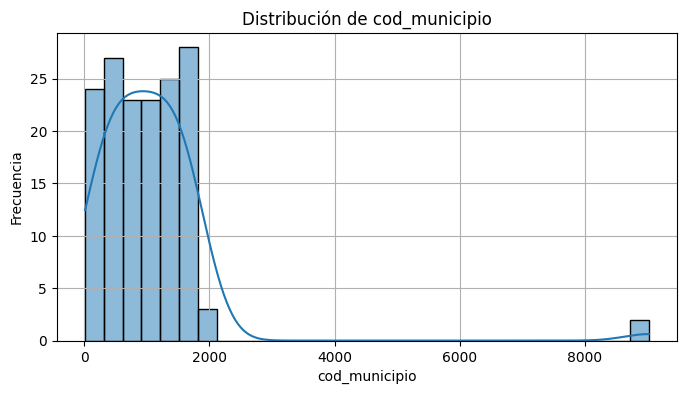

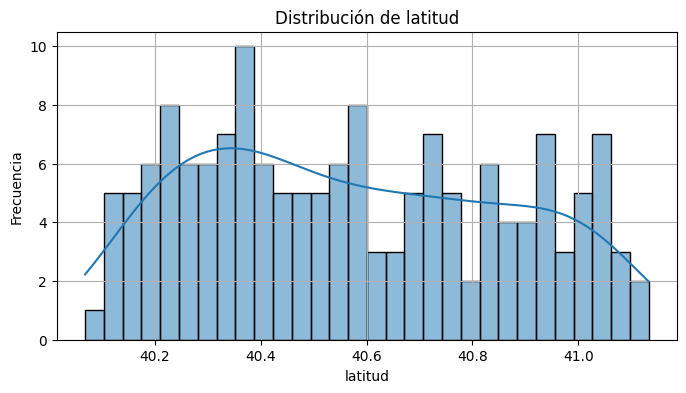

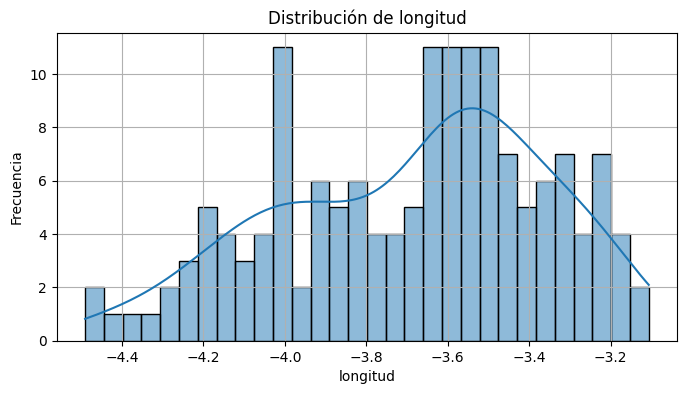

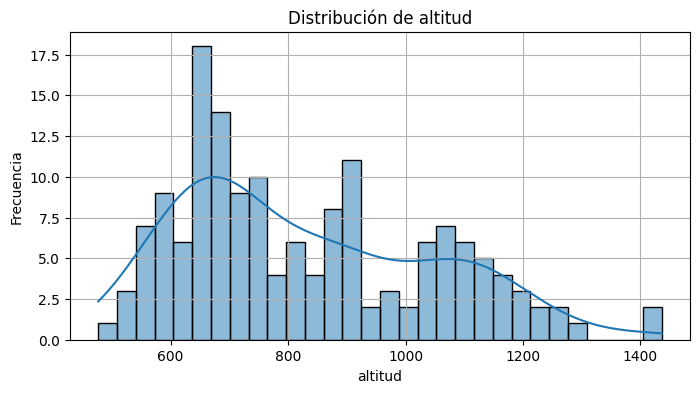

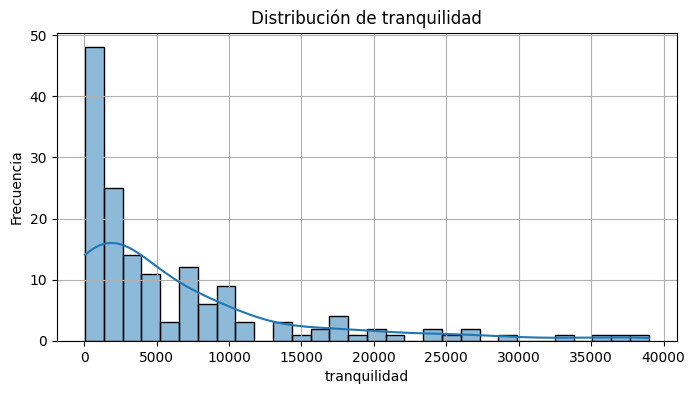

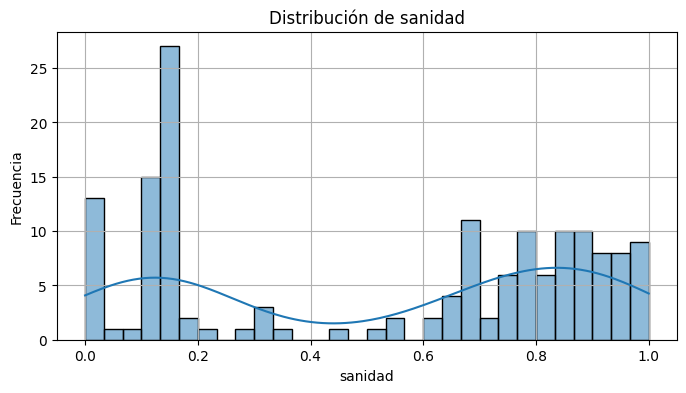

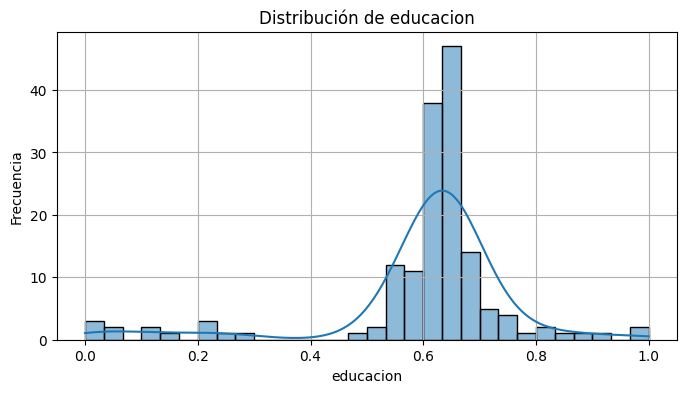

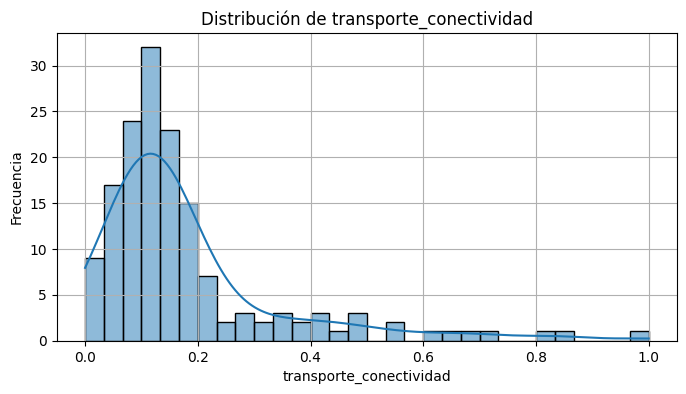

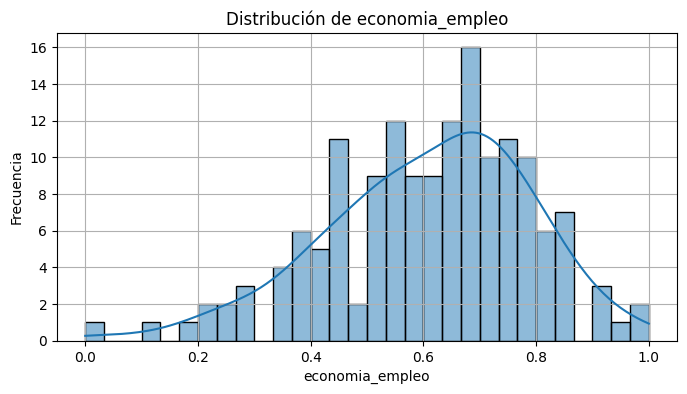

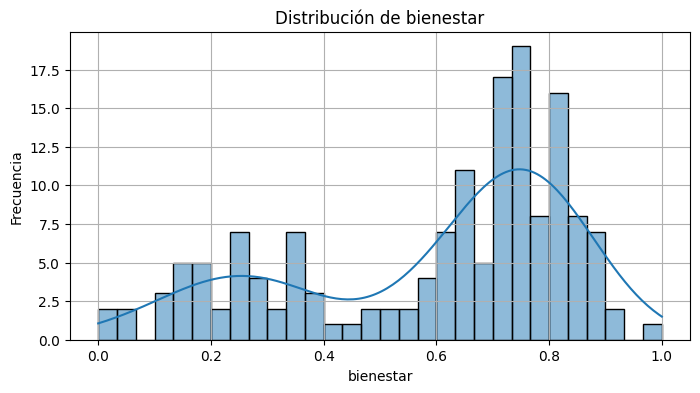

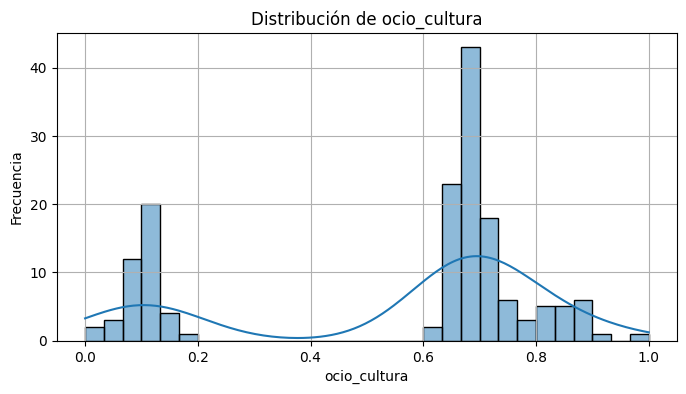

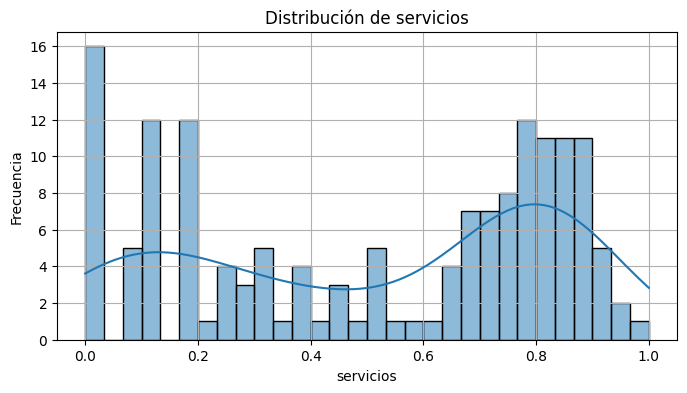

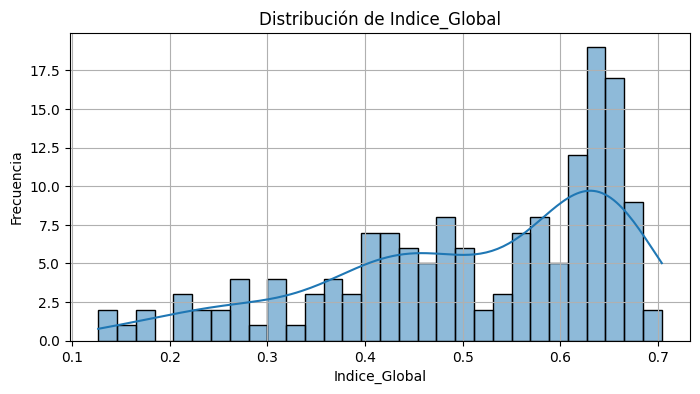

In [31]:
# plot df_indices_final numeric columns histograms
numeric_cols = df_indices_final.select_dtypes(include=["number"]).columns.tolist()
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_indices_final[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()